# Curso de Optimización (DEMAT)
## Parcial 1

| Descripción:                         | Fechas               |
|--------------------------------------|----------------------|
| Fecha de publicación del documento:  | **Abril 6, 2022**    |
| Hora de inicio:                      | **15:00**            |
| Hora límite de entrega:              | **18:00**            |


### Indicaciones

Lea con cuidado los ejercicios.

Puede usar las notas de clase y las tareas hechas para resolver el examen.

Al final, entregue el notebook con sus respuestas, junto con los códigos que hagan falta para reproducir los resultados. Si es más de un archivo, genere un archivo ZIP que contenga el notebook y los scripts adicionales.

A partir del notebook genere un archivo PDF con las respuestas y envíelo por separado 
antes de la hora límite.


## Ejercicio 1. (3 puntos)

Considere la función $f: \mathbb{R}^2 \rightarrow \mathbb{R}$ 
definida como

$$ f(\mathbf{x}) = \sum_{i=1}^n x_i^2  
+ \left(0.5 \sum_{i=1}^n i x_i  \right)^2
+ \left(0.5 \sum_{i=1}^n i x_i  \right)^4
$$

1. Para $n=2, 4, 8, 16, 32$, aplique el método de descenso máximo encontrar
   un mínimo de la función $f$, usando como punto inicial 
   $$ \mathbf{x}_0 = (5, -5, 5, -5, ..., 5, -5), $$
   y una tolerancia $\tau = \epsilon_m^{1/3}$ para terminar el algoritmo
   cuando $\|\nabla f(\mathbf{x}_k)\|<\tau$.
   
- Para calcular el tamaño de paso $\alpha_k$ use el algoritmo de backtracking.
- Reporte el valor $n$, el punto $\mathbf{x}_k$ que devuelve el algoritmo,
  el valor de $k$, la magnitud $\|\nabla f(\mathbf{x}_k)\|$ y un mensaje
  que indique si cumplió el criterio de convergencia del algoritmo.
  
2. Repita el paso ejercicio anterior usando el método de Newton,
   con tamaño de paso $\alpha_k=1$. 
   
3. Escriba un comentario sobre el desempeño de estos métodos de optimización
   cuando la dimensión $n$ aumenta.
   
> **Nota:** Puede calcular el gradiente y Hessiana de la función de 
> manera analítica o usar aproximaciones numéricas.
   
### Respuesta

In [2]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor

def f(x):
    return np.sum(x*x)+(0.5*(np.arange(1,x.shape[1]+1,1)@x.T))**2+(0.5*(np.arange(1,x.shape[1]+1,1)@x.T))**4

def gf(x):
    sum_ix_i = np.arange(1,x.shape[1]+1,1)@x.T
    return np.array( 2*x+0.5*sum_ix_i*np.arange(1,x.shape[1]+1,1)+0.25*(sum_ix_i**3)*np.arange(1,x.shape[1]+1,1))

def hes(x):
    sum_ix_i = np.arange(1,x.shape[1]+1,1)@x.T
    mat_i_j = np.repeat(np.array([np.arange(1,x.shape[1]+1,1)]),x.shape[1],axis=0)
    return np.identity(x.shape[1])*2+(0.5+0.75*sum_ix_i**2)*mat_i_j*mat_i_j.T

def backtracking(f, f_k, gf_k, x_k, p_k, alpha, ro, c):
    while (f(x_k + alpha*p_k) > (f_k + c*alpha*gf_k@p_k.T)):
        alpha = ro*alpha
    return alpha 

def gradient_descent_backtracking(f, gf, x_0, alpha, ro, c, N, T):

    x_k = x_0
    k = 0
    res = 0
    while (k < N):
        gf_k = gf(x_k)
        if np.linalg.norm(gf_k) < T:
            res = 1
            break
        p_k = -gf_k
        a_k = backtracking(f, f(x_k), gf_k, x_k, p_k, alpha, ro, c)
        x_k = x_k + a_k*p_k
        k = k + 1

    return x_k, f(x_k), gf(x_k), k, res

def newthon_method(gf, Hf, x_0, N, T):

    x_k = x_0
    k = 0
    res = 0
    points = [x_0]
    while (k < N):
        gf_k = gf(x_k)
        if np.linalg.norm(gf_k) < T:
            res = 1
            break
        Hf_k = Hf(x_k)
        try:
            p_k = cho_solve(cho_factor(Hf_k), -gf_k.squeeze())
        except:
            break
        x_k = x_k + p_k
        points.append(x_k)
        k = k + 1

    points = np.array(points)
    return points, gf(x_k), k, res

def exercise(f, gf, x_0, N, T, ro):
    print("Descenso Maximo")
    x_k, f_k, g_k, k, res = gradient_descent_backtracking(f, gf, x_0, 1, ro, 0.0001, N, T)
    print(f"El algoritmo " + ("no" if res == 0 else "") + " convergió en:")
    x_output = np.concatenate((x_k[0,:3], x_k[0,-min(3, len(x_k)-3):]if len(x_k) > 3 else []))
    print(f"k = {k}, f_k = {f_k}, ||g_k|| = {np.linalg.norm(g_k)}, x_k = {x_output}")
    return x_k

def test(gf, Hf, x_0, N, T):
    print("Metodo de Newton")
    points, g_k, k, res = newthon_method(gf, Hf, x_0, N, T)
    print(f"El algoritmo " + ("no " if res == 0 else "") + "convergió en:")
    x_k = points[-1]
    x_output = np.concatenate((x_k[0,:3], x_k[0,-min(3, len(x_k)-3):]if len(x_k) > 3 else []))
    print(f"k = {k}, ||g_k|| = {np.linalg.norm(g_k)}, x_k = {x_output}")

n = [2,4,8,16,32]
for n_i in n:
    exercise(f, gf, np.array([np.repeat(-5,n_i)*np.power(np.repeat(-1,n_i),np.arange(1,n_i+1,1))]), 100000, np.finfo(float).eps**(1/3), 0.8)
    test(gf, hes, np.array([np.repeat(-5,n_i)*np.power(np.repeat(-1,n_i),np.arange(1,n_i+1,1))]), 100000, np.finfo(float).eps**(1/3))

Descenso Maximo
El algoritmo  convergió en:
k = 96, f_k = [3.51311074e-12], ||g_k|| = 5.622988232464398e-06, x_k = [-5.58817063e-07 -1.11763413e-06]
Metodo de Newton
El algoritmo convergió en:
k = 6, ||g_k|| = 1.2340821762161328e-06, x_k = [-1.22644073e-07 -2.45288145e-07]
Descenso Maximo
El algoritmo  convergió en:
k = 109, f_k = [8.22399289e-13], ||g_k|| = 5.287547023918995e-06, x_k = [6.25797109e-08 1.08864563e-07 1.76875893e-07]
Metodo de Newton
El algoritmo convergió en:
k = 9, ||g_k|| = 2.192671097016217e-15, x_k = [-2.35487335e-17 -4.70970436e-17 -7.06459359e-17]
Descenso Maximo
El algoritmo  convergió en:
k = 516, f_k = [1.55188892e-12], ||g_k|| = 5.969062690919521e-06, x_k = [ 4.26123078e-07 -4.12388148e-07  4.35279698e-07]
Metodo de Newton
El algoritmo convergió en:
k = 10, ||g_k|| = 5.724916723983095e-06, x_k = [-3.85408023e-09 -7.70816045e-09 -1.15622407e-08]
Descenso Maximo
El algoritmo  convergió en:
k = 3425, f_k = [1.5003685e-12], ||g_k|| = 5.956208100523528e-06, x_k = 

## Ejercicio 2. (4 puntos)

Ajustar el modelo 

$$ g(x; z_1, z_2, z_3, z_4)
= z_1 - z_2\exp(-\exp(z_3+z_4\log(x)))
$$

al conjunto de puntos $\{(x_i, y_i)\}$ que se muestran a continuación:

Text(0, 0.5, 'y')

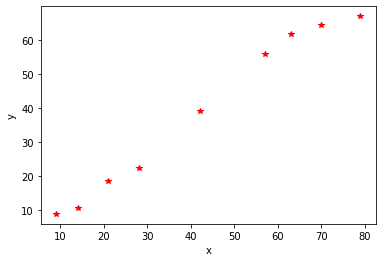

In [3]:
import matplotlib.pyplot as plt
import numpy as np

puntos = np.array([[ 9.0,  8.93],
                   [14.0, 10.80],
                   [21.0, 18.59],
                   [28.0, 22.33],
                   [42.0, 39.35],
                   [57.0, 56.11],
                   [63.0, 61.73],
                   [70.0, 64.62],
                   [79.0, 67.08]])

plt.plot(puntos[:,0], puntos[:,1], 'r*')
plt.xlabel('x')
plt.ylabel('y')

Considere los residuales 

$$ r_i(\mathbf{z}) = r_i(z_1, z_2, z_3, z_4) = g(x_1; z_1, z_2, z_3, z_4) - y_i $$

Calcule los parámetros $\mathbf{z} = (z_1, z_2, z_3, z_4)$ resolviendo el problema
de mínimos cuadrados 

$$ \min_{z} \; f(\mathbf{z}) = \frac{1}{2}\sum_{i=1}^9 r_i^2(\mathbf{z}). $$

1. Aplique el método de Levenberg-Marquart partiendo del punto inicial
   $\mathbf{z}_0 = (75, 50.0, -5, 1.1)$, una tolerancia $\tau=\sqrt{\epsilon_m}$ y $\mu_{ref}=0.001$
   (ver Tarea 7).
   Reporte el punto $\mathbf{z}_k$ que devuelve el algoritmo, el valor 
   $f(\mathbf{z}_k)$, el número de iteraciones $k$ y la variable $res$ que indica
   si el algoritmo terminó porque se cumplió la tolerancia dada.
2. Grafique los datos y la curva del modelo usando los valores del punto inicial
   $\mathbf{z}_0$ y del punto $\mathbf{z}_k$ que devuelve el algoritmo.
3. En algunos casos puede ser complicado encontrar un buen punto inicial
   para el algoritmo. Pruebe con  diferentes puntos iniciales generados 
   de manera aleatoria y conserve la mejor solución encontrada:
   
- Para $i=1, 2, ..., 25$, genere el punto inicial 
  $\mathbf{z}_0 = (z_{0,1}, z_{0,2}, z_{0,3}, z_{0,4})$ 
  aleatoriamente, de modo que
  
$$ z_{0,1} \in [50, 80], \quad z_{0,2} \in [50, 80], 
\quad z_{0,3} \in [-5, -10], \quad  z_{0,4} \in [1, 2] $$
- Para cada punto inicial, ejecute el método de Levenberg-Marquart.
- En cada iteración, imprima los valores

$$i, \quad \mathbf{z}_{k_i}, \quad  k_i,  \quad  f(\mathbf{z}_{k_i}), \quad res$$

- Defina $\mathbf{z}_{min}$ como el punto $\mathbf{z}_{k_i}$
  en el que se obtuvo el menor valor de $f(\mathbf{z})$ para $i=1,2,...25$,
  y defina  $\mathbf{z}_{ini}$ como el punto inicial $\mathbf{z}_0$ con el cual 
  se obtuvo $\mathbf{z}_{min}$.
- Grafique los datos y la curva del modelo usando los valores del punto
  $\mathbf{z}_{ini}$ y los valores del mejor punto $\mathbf{z}_{min}$.
- Revisando los valores de $f(\mathbf{z}_{k_i})$, escriba un comentario sobre 
  sobre si es fácil o no alcanzar el mejor valor $f(\mathbf{z}_{min})$ o
  que se mantengan los valores de los parámetros $z_1, z_2, z_3, z_4$
  en los intervalos que se consideraron para dar los valores iniciales.
  
  
> **Nota 1:** Debido a las exponenciales que aparecen en el modelo $g(x; \mathbf{z})$
> puede ocurrir un desbordamiento de los valores o en la solución del
> sistema de ecuaciones, etc. Puede agregar el manejo de excepciones para
> que no se interrumpa el ciclo que genera a los puntos $\mathbf{z}_{k_i}$.
> Como el objetivo es quedarse con el mejor punto, no importa si en  
> algunos casos el algoritmo falla o se interrumpe por generarse una excepción.

> **Nota 2:** Para generar un número aleatorio con distribución uniforme
> en el intervalo $[a,b]$ puede usar $a + np.random.rand(1)*(b-a)$.

   

### Respuesta

In [18]:
import plotly.graph_objects as go
import itertools

def R(z, pts):
    return z[0,0] - z[0,1] * np.exp(- np.exp(z[0,2] + z[0,3] * np.log(pts[:, 0]))) - pts[:,1]

def J(z, pts):
    x = pts[:, 0]
    lx = np.log(x)
    n = pts.shape[0]
    return np.array(
        [
            np.ones(n),
            -np.exp( - np.exp(z[0,2] + z[0,3] * lx)),
            z[0,1]* np.exp( - np.exp(z[0,2] + z[0,3] * lx) + z[0,2] + z[0,3]*lx),
            z[0,1] * lx * np.exp( - np.exp(z[0,2] + z[0,3] * lx) + z[0,2] + z[0,3]*lx)
        ]
    ).T

def LevenbergMarquart(R, J, zk, mu_0, N, T):
    res = 0
    Rk = R(zk)
    Jk = J(zk)
    fk = Rk.T @ Rk / 2
    A = Jk.T @ Jk
    g = Jk.T @ Rk
    mu = min(mu_0, np.amax(np.diag(A)))
    k = 0

    while (k < N):
        pk = np.linalg.solve( A + mu * np.identity(A.shape[0]), -g )
        if np.linalg.norm(pk) < T:
            res = 1
            break
            
        zk = zk + pk
        Rk = R(zk)
        f_an = fk
        fk = Rk.T @ Rk / 2
        
        rho = (f_an - fk) / (-pk.T@g + 0.5*mu * pk.T @ pk)
        
        if rho < 0.25:
            mu = 2 * mu
        elif rho > 0.75:
            mu = mu/3
        
        Jk = J(zk)
        A = Jk.T @ Jk
        g = Jk.T @ Rk
        k = k + 1
    return zk, fk, k, res

def test(R, J, z_0, pts, mu_0, N, T):
    print("LevenbergMarquart")
    z_k, f_k, k, res = LevenbergMarquart(lambda x : R(x,puntos), lambda x : J(x,puntos), z_0, mu_0, N, T)
    print(f"El algoritmo " + ("no" if res == 0 else "") + " convergió en:")
    z_output = np.concatenate((z_k[0,:3], z_k[0,-min(3, len(z_k)-3):]if len(z_k) > 3 else []))
    print(f"k = {k}, f_k = {f_k}, x_k = {z_output}")
    
    p = 100
    xtl = np.min(pts[:,0])
    xtr = np.max(pts[:,0])
    x = np.linspace(xtl, xtr, 100).T
    y = np.zeros((100,1))
    fig = go.Figure()
    xtl, xtr = xtl - (xtr - xtl)/10, xtr + (xtr - xtl)/10
    x = np.linspace(xtl,xtr,p)
    fig.add_trace(
        go.Scatter(
            x=x,
            y=R(z_k, np.column_stack((x, y))),
        )
    )
    fig.add_trace(
        go.Scatter(
            x=pts[:,0],
            y=pts[:,1],
            mode="markers"
        )
    )
    fig.update_layout(
        template="simple_white",
        width=500,
        height=500
    )
    fig.show()

# Test 1
z_0 = np.array([[75, 50, -5, 1.1]])
mu_0 = 0.001
N = 1000 
T = np.finfo(float).eps**(1/2)
test(R, J, z_0, puntos, mu_0, N, T)

LevenbergMarquart
El algoritmo  convergió en:
k = 13, f_k = 1820.88939375, x_k = [  42.57625      33.64660572 -133.71595421]


_

```







```

---

## Ejercicio 3 (3 puntos)

Queremos encontrar una solución del problema de optimización con
restricciones 

$$ \min_{x_1,x_2} f(x_1,x_2) = 2(x_1^2 + x_2^2 - 1) - x_1 $$

sujeto a que el punto $(x_1,x_2)$ esté sobre el círculo unitario, es decir,

$$ x_1^2 + x_2^2 - 1 = 0.$$

Una manera de hallar una aproximación  es convertir este problema
de optimización sin restricciones. Un enfoque es el de penalización cuadrática
en el cual se construye la función 

$$ Q(x_1, x_2; \mu) = f(x_1,x_2) + \frac{\mu}{2} g(x_1, x_2),$$

donde $g(x_1, x_2) = (x_1^2 + x_2^2 - 1)^2$ es el cuadrado de la restricción
que queremos que se cumpla.

La idea es:

1. Dar un punto inicial $\mathbf{x}_0 =(10, 8)$ y un valor 
   del parámetro $\mu_0= 1$.
2. Para $r=0, 1, 2, 3$:

- Calcular el mínimo de la función $Q(\mathbf{x}; \mu_r)$ 
  usando el punto inicial $\mathbf{x}_0$
- Imprimir $\mu_r$, el óptimo $\mathbf{x}_k$ que devuelve el algoritmo,
  los valores $Q(\mathbf{x}_k; \mu_k)$,  $f(\mathbf{x}_k)$ y
  $g(\mathbf{x}_k)$
- Hacer $\mu_{r+1} = 10\mu_r$ y $\mathbf{x}_0=\mathbf{x}_k$.  

El último punto $\mathbf{x}_k$ generado debería ser una aproximación
de la solución del problema original porque  $Q(\mathbf{x}; \mu_r)= f(\mathbf{x})$
si $\mathbf{x}$ cumple la restricción. Si no, 
$Q(\mathbf{x}; \mu_r)> f(\mathbf{x})$ y el valor de $Q$ aumenta conforme
aumenta el valor de $\mu_r$. De este modo, al ir incrementando 
gradualmente el valor $\mu$, se penaliza cada vez más a los puntos que 
no satisfacen la restricción y eso hace que en cada iteración $r$
se obtenga un punto que está más cerca de cumplir la restricción. 

Note que en cada iteración $r$, se usa como punto inicial para el
algoritmo de optimización el punto que se obtuvo en la iteración
anterior. Esto ayuda a que los óptimos que se obtienen en cada iteración
gradualmente se vayan cumpliendo la restricción.

### Respuesta

In [5]:
def Q(x, mu):
    return (2*(x[0,0]**2+x[0,1]**2-1)-x[0,0]) + (mu/2)*(x[0,0]**2+x[0,1]**2-1)**2

def dQ(x, mu):
    return np.array(
        [
            (4*(x[0,0])-1) + 2*(mu)*(x[0,0]**2+x[0,1]**2-1)*(x[0,0]),
            (4*(x[0,1])) + 2*(mu)*(x[0,0]**2+x[0,1]**2-1)*(x[0,1])
        ]
    )

def solve(x_0, mu_0, r):
    mu_k = mu_0
    x_k = x_0
    for r_i in r:
        x_k = exercise(lambda x : Q(x, mu_k), lambda x : dQ(x, mu_k), x_k, 100000, np.finfo(float).eps**(1/3), 0.8)
        print("Valores: ", f"mu_k = {mu_k}", f"x_k = {x_k}", f"Q(x_k, mu_k) = {Q(x_k, mu_k)}", f"f(x_k) = {(2*(x_k[0,0]**2+x_k[0,1]**2-1)-x_k[0,0])}", f"g(x_k) = {(x_k[0,0]**2+x_k[0,1]**2-1)**2}")
        mu_k = 10*mu_k

r = [0,1,2,3]
x_0 = np.array([[10,8]])
solve(x_0, 1, r)


Descenso Maximo
El algoritmo  convergió en:
k = 336, f_k = -1.7280643278037209, ||g_k|| = 5.909128043102285e-06, x_k = [4.23855719e-01 1.64574741e-96]
Valores:  mu_k = 1 x_k = [[4.23855719e-01 1.64574741e-96]] Q(x_k, mu_k) = -1.7280643278037209 f(x_k) = -2.0645483780002962 g(x_k) = 0.6729681003931507
Descenso Maximo
El algoritmo  convergió en:
k = 193, f_k = -1.1095412580698891, ||g_k|| = 5.78859576982893e-06, x_k = [9.24176673e-001 2.56151489e-101]
Valores:  mu_k = 10 x_k = [[9.24176673e-001 2.56151489e-101]] Q(x_k, mu_k) = -1.1095412580698891 f(x_k) = -1.215971627472681 g(x_k) = 0.021286073880558365
Descenso Maximo
El algoritmo  convergió en:
k = 105, f_k = -1.0112217338041594, ||g_k|| = 5.413375138374477e-06, x_k = [9.92490734e-001 1.66717127e-101]
Valores:  mu_k = 100 x_k = [[9.92490734e-001 1.66717127e-101]] Q(x_k, mu_k) = -1.0112217338041594 f(x_k) = -1.0224150189462633 g(x_k) = 0.000223865702842079
Descenso Maximo
El algoritmo  convergió en:
k = 33, f_k = -1.001124718609316, ||g